In [1]:
import tkinter as tk
from tkinter import ttk
import os
from tkinter import filedialog
from typing import List
import xlstools
from xlstools import open_workbook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import openpyxl
from termcolor import colored

def lista_contenida(lista_pequena, lista_grande):
    # Convertimos las listas en conjuntos para aprovechar la eficiencia de las operaciones de conjuntos
    conjunto_pequeno = set(lista_pequena)
    conjunto_grande = set(lista_grande)
    
    # Verificamos si conjunto_pequeno es un subconjunto de conjunto_grande
    return conjunto_pequeno.issubset(conjunto_grande)

SPATIAL_RESOLUTION = 0.1 #cm
BIN_WIDTH = 1 #cGy
DOSE_UNIT = 'cGy'
VOLUME_UNIT = '%'
MAX_DOSE_ABS_VOLUME = 0.03 #cm3
corrected_dict = {}


class Structure:
    def __init__(self, label, dose_axis, cumulated_percent_volume_axis):
        self.label = 'Paciente' if label == 'Paciente(Unsp.Tiss.)' else label
        self.volume = None
        self.dose_axis = dose_axis
        self.cumulated_percent_volume_axis = cumulated_percent_volume_axis
        self.differential_percent_volume_axis = -np.diff(self.cumulated_percent_volume_axis, 
                                              axis=0, 
                                              prepend=self.cumulated_percent_volume_axis[0])
        self.mean = self._mean_calculation()
        self.constraints = []

    def _mean_calculation(self):
        sum_dummy = (self.differential_percent_volume_axis*self.dose_axis).sum()
        sum_dummy /= self.differential_percent_volume_axis.sum()
        sum_dummy -= 1
        return sum_dummy

    def volume_update(self, volume: float) -> None:
        self.volume = volume
    
    def label_update(self, name: float) -> None:
        self.label = name

    def volume_function(self, dose):   # Entrada de dosis en cGy, devuelve en porcentaje de volumen
        y_min = self.cumulated_percent_volume_axis[0]
        y_max = self.cumulated_percent_volume_axis[-1]
        dvh = interp1d(self.dose_axis, self.cumulated_percent_volume_axis, kind='linear', bounds_error=False, fill_value=(y_min, y_max))
        return round(dvh(dose).item(), 1)
    
    def dose_function(self, volume):   # Entrada de volumen en porcentaje, devuelve dosis en cGy
        y_min = self.dose_axis[0]
        y_max = self.dose_axis[-1]
        vdh = interp1d(self.cumulated_percent_volume_axis, self.dose_axis, kind='linear', bounds_error=False, fill_value=(y_min, y_max))
        return round(vdh(volume).item(), 1)

class DVH:
    def __init__(self, file_path):
        # self.file_path = self._file_finder('Seleccione el archivo DVH.')
        self.file_path = file_path
        self.patient_id, self.plan_name, self.date_and_time, self.structures = self._DVH_data_parser()

    def _file_finder(self, window_title: str) -> str:
        tk.Tk().withdraw() # prevents an empty tkinter window from appearing
        my_directory = filedialog.askopenfilename(initialdir=os.getcwd(), 
                                           title=window_title, 
                                           filetypes=[("TXT Files", "*.txt")])
        return(my_directory)

    def _DVH_data_parser(self) -> List:
            try:
                with open(self.file_path, 'r') as file:
                    data = file.readlines()
                    header = data[0]

                    patient_id = header.split(' ')[2]
                    plan_name = header.split(' ')[6]
                    date_and_time = data[-1]

                    data_dict = {}
                    for row in data[3:-3]:
                        row = row.replace('\n','').split('                    ')
                        key = row[0]
                        values = [float(row[1]), float(row[2])]
                        
                        # Verificar si la key ya existe en el diccionario
                        if key in data_dict.keys():
                            data_dict[key].append(values)
                        else:
                            data_dict[key] = [values]

                    structures_dict = {}
                    for key in data_dict:
                        # convierto a numpy.array para poder transponer
                        dummy = np.array(data_dict[key]).T
                        if key in ['Camilla', 'Espuma', 'isoctsim']:     # Estructuras que no nos interesa evaluar
                            continue
                        structures_dict[key.upper()]= Structure(key.upper(),dummy[0],dummy[1])
                           
                    return patient_id, plan_name, date_and_time, structures_dict
                
            except FileNotFoundError:
                print(f"El archivo '{self.archivo}' no fue encontrado.")
            except Exception as e:
                print(f"Error al leer el archivo: {e}")

    def plot(self, DIFFERENTIAL_DVH: bool=False) -> None:
        print('RESUMEN DEL DVH INGRESADO:')
        print(f'\tPatient ID: {self.patient_id}')
        print(f'\tPlan Name: {self.plan_name}')
        print(f'\tFecha y Hora: {self.date_and_time}')
        print('\n')

        plt.figure()
        for structure in list(self.structures.values()):
            # print(f'{structure.label}:\t{structure.mean:.1f} cGy')
            if DIFFERENTIAL_DVH:
                plt.plot(structure.dose_axis, 
                         structure.differential_percent_volume_axis, 
                         label=structure.label)
                plt.title('Differential dose-volume histogram')
                plt.ylim([0,1.5])
            else:
                plt.plot(structure.dose_axis, 
                         structure.cumulated_percent_volume_axis, 
                         label=structure.label)
                plt.title('Cumulated dose-volume histogram')
     
        plt.xlabel('Dosis[cGy]')
        plt.ylabel('Volume[%]')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.show()

class Constraint:
    def __init__(self, constraints_chart_line):
        self.structure_name, self.type, self.ideal_dose, self.ideal_volume, self.acceptable_dose, self.acceptable_volume = constraints_chart_line
        self.structure_name = self.structure_name.upper()
        self.VERIFIED_IDEAL = (False, 0.0)
        self.VERIFIED_ACCEPTABLE = (False, 0.0)
        self.ACCEPTABLE_LV_AVAILABLE = self.acceptable_dose != 'None'

    def _evaluate(self, structure, ref1, ref2):   #ref1 y ref2 despues podran ser contraint ideal o aceptable
        constraint_types = ['V(D)>V_%', 'V(D)>V_cc', 'V(D)<V_%', 'V(D)<V_cc', 'D(V_%)<D', 'D(V_cc)<D', 'Dmax', 'Dmedia']

        if self.type in constraint_types[:4]:
            is_superior = self.type in (constraint_types[2], constraint_types[3])
            abs_volume = self.type in (constraint_types[1], constraint_types[3])

            ref_dose = float(ref1)
            ref_vol  = float(ref2)
            result = structure.volume_function(ref_dose)
            result = result * structure.volume/100.0 if abs_volume else result

            # print(f'dvh percent: {result}')

            if (is_superior and result <= ref_vol) or ((not is_superior) and result >= ref_vol):
                PASS = True
            else:
                PASS = False
            #print(PASS, result, ref_vol, ref_dose)
            return (PASS, round(result, 1))
            
            
        elif self.type in constraint_types[4:6]:
            abs_volume = self.type == constraint_types[5]

            ref_vol   = float(ref1)  #cc
            ref_vol   = float( ref_vol*100.0/structure.volume if abs_volume else ref_vol ) #%
            ref_dose = float(ref2)
            result = structure.dose_function(ref_vol)
            # print(f'vdh percent: {result}')
            if result <= ref_dose:
                PASS = True
            else:
                PASS = False
            return (PASS, round(result, 1))
            
        elif self.type in constraint_types[6:]:
            dmax       = self.type == constraint_types[6]
            dmed       = self.type == constraint_types[7]

            if dmax:
                ref_vol   = float( MAX_DOSE_ABS_VOLUME * 100.0/structure.volume)  #%
            ref_dose  = float(ref1)
            result = structure.mean if dmed else structure.dose_function(ref_vol)
            # print(f'med o max: {result}')
            if result <= ref_dose:
                PASS = True
            else:
                PASS = False
            return (PASS, round(result, 1))
            
        else:
            PASS = False
            print('No existe el tipo de constraint en las lista de tipos de constraints.')
            return (PASS, 'None')


    def verify(self, structure: Structure):   
        #print(f'Verifico ideal?: {self.VERIFIED_IDEAL[0]}, Hay level aceptable?: {self.ACCEPTABLE_LV_AVAILABLE}')
        self.VERIFIED_IDEAL = self._evaluate(structure, self.ideal_dose, self.ideal_volume)

        if not self.VERIFIED_IDEAL[0] and self.ACCEPTABLE_LV_AVAILABLE:
            
            self.VERIFIED_ACCEPTABLE = self._evaluate(structure, self.acceptable_dose, self.acceptable_volume) 

        #print(f'Constraint: {self.type} - {self.structure_name} - Ideal: {self.ideal_dose} {self.ideal_volume} - Aceptable: {self.acceptable_dose} {self.acceptable_volume}')
            
class Prescription:
    def __init__(self, constraint_excel_filepath, presc_template_name):
        self.constraint_excel_filepath = constraint_excel_filepath
        self.presc_template_name = presc_template_name.upper()
        self.structures = {}

        constraints_chart = self._prescription_importer()

        target_chart = constraints_chart.pop(0)
        constraints_chart = [sublist[1:] for sublist in constraints_chart[0]]


        self.target_structures = {}
        for target_structure in target_chart:
            self.target_structures[target_structure[0]] = [int(x) for x in target_structure[1:3]]

        for constraint_chart_line in constraints_chart:
            new_structure_name = constraint_chart_line[0]
            if new_structure_name != 'None':
                structure_name = new_structure_name.upper()
                self.structures[structure_name] = []
                self.structures[structure_name].append(Constraint(constraint_chart_line))
            else:
                self.structures[structure_name].append(Constraint(constraint_chart_line))   

            
    def _prescription_importer(self):
        workbook = openpyxl.load_workbook(self.constraint_excel_filepath)
        # for name in workbook.sheetnames:
        #     print(name)
        excel_data = xlstools.cell_data_importer(open_workbook(self.constraint_excel_filepath, self.presc_template_name),
                                                (4,'A'), 
                                                (45,'G'))

        chunks_charts = xlstools.none_based_data_parser(excel_data)

        assert len(chunks_charts)==2, "Error de importacion de chunks. Numero de chunks: "+f'{len(chunks_charts)}'
        if len(chunks_charts)==2:
            constraints_chart = [chunks_charts[0][1:], chunks_charts[1][2:]]

        return constraints_chart

    def print(self):
        print(f'Resumen de datos ingresados de la prescripcion:'.upper())
        print(f'\tPresc. Name: {self.presc_template_name}')
        print(f'\tPath: {self.constraint_excel_filepath}')
        print('\tVolumenes Target: [Dosis total, Dosis diaria]')
        for structure_name, content in self.target_structures.items():
            print(f'\t\t{structure_name}:\t',content)
        print('\n')
        
        dummy = []
        for structure_name, constraints in self.structures.items():
            for constraint in constraints:
                if constraint.VERIFIED_IDEAL[0]:
                    check = f'    PASS IDEAL: {constraint.VERIFIED_IDEAL[1]}'  
                elif constraint.VERIFIED_ACCEPTABLE[0]:
                    check = f'    PASS ACEPTABLE: {constraint.VERIFIED_ACCEPTABLE[1]}'
                else:
                    check = f'    FAIL: {constraint.VERIFIED_ACCEPTABLE[1]}'
                dummy.append([structure_name, constraint.type, constraint.ideal_dose, constraint.ideal_volume, constraint.acceptable_dose, constraint.acceptable_volume, check])
        print(pd.DataFrame(dummy).to_string(header=False, index=False))

def match_strings_and_volume_entry(dvh_list_dummy, presc):
    def request_needed_volume(dvh_list_dummy, presc):
        need_volume_types = ['V(D)>V_cc', 'V(D)<V_cc', 'D(V_cc)<D', 'Dmax']
        needing_volume = []

        # Paso 1: Detectar las estructuras que requieren volumen
        for label, constraints in presc.structures.items():
            for constraint in constraints:
                if constraint.type in need_volume_types:
                    needing_volume.append(label)
                    break

        # Paso 2: Filtrar estructuras que ya tienen volume distinto de 0
        filtered = []
        dvh_structures = dvh_list_dummy[0].structures
        for label in needing_volume:
            if label in dvh_structures:
                vol = dvh_structures[label].volume
                if vol is None or vol == 0:
                    filtered.append(label)
            else:
                filtered.append(label)  # Si no está en DVH, igual lo necesita

        return list(set(filtered))

    def launch_gui(presc_names, dvh_names, needs_volume):
        root = tk.Tk()
        root.title("Emparejar estructuras y asignar volúmenes")
        tk.Label(root, text="Empareje estructuras del protocolo con el DVH. Ingrese volumen si corresponde.")\
            .grid(row=0, columnspan=3, pady=10)

        dropdown_vars = {}
        volume_entries = {}

        row = 1
        for presc_name in presc_names:
            name_needs_match = presc_name not in dvh_names
            name_needs_volume = presc_name in needs_volume

            if not name_needs_match and not name_needs_volume:
                continue

            tk.Label(root, text=presc_name).grid(row=row, column=0)

            # Dropdown para renombrar (activado solo si es necesario)
            var = tk.StringVar(value=presc_name)
            dropdown = ttk.Combobox(root, textvariable=var, values=dvh_names, state="readonly")
            dropdown.grid(row=row, column=1)
            if not name_needs_match:
                dropdown.configure(state="disabled")
            dropdown_vars[presc_name] = var

            # Entry de volumen si es necesario
            if name_needs_volume:
                entry = tk.Entry(root)
                entry.grid(row=row, column=2)
                volume_entries[presc_name] = entry

            row += 1

        def on_submit():
            for presc_name in dropdown_vars:
                selected_dvh_key = dropdown_vars[presc_name].get()
                if not selected_dvh_key:
                    print(f"⚠️ No se asignó estructura para: {presc_name}")
                    continue
                replacement_dict[presc_name] = selected_dvh_key

                if presc_name in volume_entries:
                    try:
                        vol = float(volume_entries[presc_name].get())
                        volume_dict[presc_name] = vol
                    except ValueError:
                        print(f"⚠️ Entrada inválida de volumen para {presc_name}")
            root.destroy()

        tk.Button(root, text="OK", command=on_submit).grid(row=row + 1, columnspan=3, pady=10)
        root.mainloop()
        return replacement_dict, volume_dict

    def apply_corrections(dvh, replacement_dict, volume_dict):
        new_structures = {}
        for old_key, structure in dvh.structures.items():
            matched_presc = next((k for k, v in replacement_dict.items() if v == old_key), None)
            new_key = matched_presc if matched_presc else old_key
            structure.label = new_key
            new_structures[new_key] = structure
            if new_key in volume_dict:
                new_structures[new_key].volume = volume_dict[new_key]
        dvh.structures = new_structures

    # --- Lógica principal ---
    presc_names = list(presc.structures.keys())
    dvh_names = list(dvh_list_dummy[0].structures.keys())
    needs_volume = request_needed_volume(dvh_list_dummy, presc)

    replacement_dict = {}
    volume_dict = {}

    any_name_mismatch = any(name not in dvh_names for name in presc_names)
    any_volume_needed = len(needs_volume) > 0

    if any_name_mismatch or any_volume_needed:
        replacement_dict, volume_dict = launch_gui(presc_names, dvh_names, needs_volume)

    for dvh in dvh_list_dummy:
        apply_corrections(dvh, replacement_dict, volume_dict)


    # --- FLUJO PRINCIPAL ---
    dvh = dvh_list_dummy[0]
    dvh_names = list(dvh.structures.keys())
    presc_names = list(presc.structures.keys())

    replacement_dict = {}
    volume_dict = {}

    needs_volume = request_needed_volume(dvh_list_dummy, presc)
    launch_gui(presc_names, dvh_names, needs_volume)
    apply_corrections(dvh, replacement_dict, volume_dict)

def dose_police_in_action(dvh_list_dummy: List, presc: Prescription):
    # CHEQUEANDO SI COINCIDEN LOS NOMBRES DE LAS ESTRUCTURAS EN PRESCRIPCION Y DVH y asignando volumenes
    match_strings_and_volume_entry(dvh_list_dummy, presc)

    # CHEQUEANDO SI HIZO BIEN EL PREPROCESAMIENTO DEL DVH
    # print('Estructuras presc:')
    # for name in presc.structures.keys():
    #     print(f'\t{name}')
    # print('Estructuras dvh:')
    # for structure in dvh_list_dummy[0].structures.values():
    #     print(f'\t{structure.label}: {structure.volume} cc')

    # CHEQUEANDO CONSTRAINTS
    for p_name in list(presc.structures.keys()):
        print(f'{p_name} constraints:')
        for constraint in presc.structures[p_name]:
            if p_name in ['PTV_BOOST_TOTAL', 'PTV_BOOST']: continue  # PTV_BOOST_TOTAL no tiene constraints
            constraint.verify(dvh_list_dummy[0].structures[p_name])

            if not constraint.ACCEPTABLE_LV_AVAILABLE:
                if constraint.VERIFIED_IDEAL[0]:
                    print(colored(f"    PASA IDEAL: {constraint.type}: {constraint.ideal_dose} {constraint.ideal_volume} -> {constraint.ideal_dose} {constraint.VERIFIED_IDEAL[1]}",'green'))
                else:
                    print(colored(f"    NO PASA: {constraint.type}: {constraint.ideal_dose} {constraint.ideal_volume} -> {constraint.ideal_dose} {constraint.VERIFIED_IDEAL[1]}",'red'))
            else:
                if constraint.VERIFIED_IDEAL[0]:
                    print(colored(f"    PASA IDEAL: {constraint.type}: {constraint.ideal_dose} {constraint.ideal_volume} -> {constraint.ideal_dose} {constraint.VERIFIED_IDEAL[1]}",'green'))
                elif constraint.VERIFIED_ACCEPTABLE[0]:
                    print(colored(f"    PASA ACEPTABLE: {constraint.type}: {constraint.acceptable_dose} {constraint.acceptable_volume} -> {constraint.acceptable_dose} {constraint.VERIFIED_ACCEPTABLE[1]}",'yellow'))
                else:
                    print(colored(f"    NO PASA: {constraint.type}: {constraint.acceptable_dose} {constraint.acceptable_volume} -> {constraint.acceptable_dose} {constraint.VERIFIED_ACCEPTABLE[1]}",'red'))


RESUMEN DEL DVH INGRESADO:
	Patient ID: 1~20123478
	Plan Name: PARARRECTALmLN
	Fecha y Hora: 2025-06-26-Thu  16:28:47




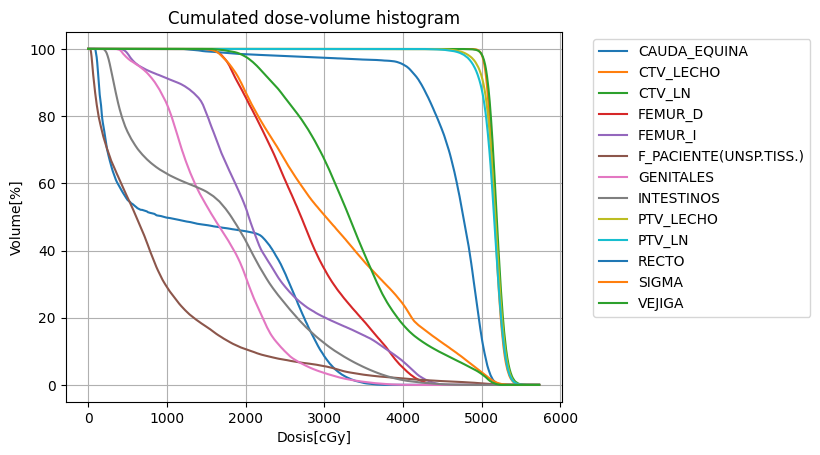

In [8]:
file_name = '20123478_PARARRECTALmLN_DVH_1' + '.txt'
presc_template_name = 'PARARRECTAL'

folder_path = './dvhs/'
#constraint_excel_file_path = 'P:/8 - Físicos Médicos/Natalia Espector/2024 - Protocolos clínicos/Protocolo de constraints.xlsx'
dvh = DVH(folder_path+file_name)

#presc = Prescription(constraint_excel_file_path, presc_template_name)

dvh.structures['PTV_LECHO'].volume_update(862.536)
dvh.structures['PTV_LN'].volume_update(836.747)
dvh.structures['INTESTINOS'].volume_update(907.48)

dvh.structures['PTV_LECHO']
del dvh.structures['PTV_TOTAL']
del dvh.structures['PRV_CAUDA_EQUINA']
del dvh.structures['F_PTV_TOTAL']
del dvh.structures['BOLUS']
del dvh.structures['PACIENTE']

dvh.plot()

#dose_police_in_action([dvh], presc) 

In [ ]:
file_name = '20123478_PARARRECTALmLNnorm_DVH_1' + '.txt'
presc_template_name = 'PARARRECTAL'

folder_path = 'P:/8 - Físicos Médicos/Roy/INTECNUS-Dose_Police/'
constraint_excel_file_path = 'P:/8 - Físicos Médicos/Natalia Espector/2024 - Protocolos clínicos/Protocolo de constraints.xlsx'
dvh = DVH(folder_path+file_name)
presc = Prescription(constraint_excel_file_path, presc_template_name)

dvh.structures['PTV_LECHO'].volume_update(862.536)
dvh.structures['PTV_LN'].volume_update(836.747)
dvh.structures['INTESTINOS'].volume_update(907.48)

dose_police_in_action([dvh], presc) 

PTV_LECHO constraints:
    PASA IDEAL: V(D)>V_%: 4900 95 -> 4900 95.0
    NO PASA: Dmax: 5350 None -> 5350 5469.8
PTV_LN constraints:
    PASA ACEPTABLE: V(D)>V_%: 4750 95 -> 4750 97.3
    NO PASA: Dmax: 5350 None -> 5350 5549.1
VEJIGA constraints:
    PASA IDEAL: V(D)<V_%: 5000 5 -> 5000 2.2
    PASA IDEAL: V(D)<V_%: 4000 35 -> 4000 28.6
    PASA ACEPTABLE: V(D)<V_%: 3500 70 -> 3500 53.8
INTESTINOS constraints:
    PASA IDEAL: V(D)<V_cc: 5500 5 -> 5500 0.0
    PASA IDEAL: V(D)<V_cc: 4500 40 -> 4500 0.9
    PASA IDEAL: V(D)<V_cc: 3500 300 -> 3500 53.5
    PASA IDEAL: V(D)<V_%: 3500 35 -> 3500 5.9
    PASA IDEAL: V(D)<V_cc: 3000 400 -> 3000 128.9
FEMUR_I constraints:
    PASA IDEAL: V(D)<V_%: 4400 5 -> 4400 3.9
    PASA IDEAL: V(D)<V_%: 4000 35 -> 4000 11.6
    PASA IDEAL: V(D)<V_%: 3000 50 -> 3000 26.7
FEMUR_D constraints:
    PASA IDEAL: V(D)<V_%: 4400 5 -> 4400 0.3
    PASA IDEAL: V(D)<V_%: 4000 35 -> 4000 8.4
    PASA IDEAL: V(D)<V_%: 3000 50 -> 3000 41.7


In [ ]:
file_name = '20123478_PARARRECTALmLN3_DVH_1' + '.txt'
presc_template_name = 'PARARRECTAL'

folder_path = 'P:/8 - Físicos Médicos/Roy/INTECNUS-Dose_Police/'
constraint_excel_file_path = 'P:/8 - Físicos Médicos/Natalia Espector/2024 - Protocolos clínicos/Protocolo de constraints.xlsx'
dvh = DVH(folder_path+file_name)
presc = Prescription(constraint_excel_file_path, presc_template_name)

dvh.structures['PTV_LECHO'].volume_update(862.536)
dvh.structures['PTV_LN'].volume_update(836.747)
dvh.structures['INTESTINOS'].volume_update(907.48)

dose_police_in_action([dvh], presc) 

PTV_LECHO constraints:
    PASA ACEPTABLE: V(D)>V_%: 4750 95 -> 4750 95.3
    NO PASA: Dmax: 5350 None -> 5350 5413.6
PTV_LN constraints:
    PASA ACEPTABLE: V(D)>V_%: 4750 95 -> 4750 95.0
    NO PASA: Dmax: 5350 None -> 5350 5447.7
VEJIGA constraints:
    PASA IDEAL: V(D)<V_%: 5000 5 -> 5000 1.4
    PASA IDEAL: V(D)<V_%: 4000 35 -> 4000 21.7
    PASA IDEAL: V(D)<V_%: 3500 50 -> 3500 48.3
INTESTINOS constraints:
    PASA IDEAL: V(D)<V_cc: 5500 5 -> 5500 0.0
    PASA IDEAL: V(D)<V_cc: 4500 40 -> 4500 0.9
    PASA IDEAL: V(D)<V_cc: 3500 300 -> 3500 48.1
    PASA IDEAL: V(D)<V_%: 3500 35 -> 3500 5.3
    PASA IDEAL: V(D)<V_cc: 3000 400 -> 3000 122.5
FEMUR_I constraints:
    PASA IDEAL: V(D)<V_%: 4400 5 -> 4400 2.3
    PASA IDEAL: V(D)<V_%: 4000 35 -> 4000 8.7
    PASA IDEAL: V(D)<V_%: 3000 50 -> 3000 25.1
FEMUR_D constraints:
    PASA IDEAL: V(D)<V_%: 4400 5 -> 4400 1.4
    PASA IDEAL: V(D)<V_%: 4000 35 -> 4000 9.0
    PASA IDEAL: V(D)<V_%: 3000 50 -> 3000 40.5


In [ ]:
file_name = '96249168_PRmVSmLNVMAT_DVH_1' + '.txt'
presc_template_name = 'PR+VS+LN 6000-20FX'

folder_path = 'P:/8 - Físicos Médicos/Roy/INTECNUS-Dose_Police/'
constraint_excel_file_path = 'P:/8 - Físicos Médicos/Natalia Espector/2024 - Protocolos clínicos/Protocolo de constraints.xlsx'
dvh = DVH(folder_path+file_name)
presc = Prescription(constraint_excel_file_path, presc_template_name)

dvh.structures['PTV_PR'].volume_update(105.56)
dvh.structures['PTV_VS'].volume_update(26.44)
dvh.structures['INTESTINOS'].volume_update(489.44)
dvh.structures['SIGMA'].volume_update(63.26)
dvh.structures['CAUDA_EQUINA'].volume_update(25.03)

dose_police_in_action([dvh], presc) 

PTV_PR constraints:
    PASA IDEAL: V(D)>V_%: 5880 95 -> 5880 97.5
    PASA IDEAL: Dmax: 6420 None -> 6420 6392.4
PTV_VS constraints:
    PASA IDEAL: V(D)>V_%: 5880 95 -> 5880 99.8
    PASA IDEAL: Dmax: 6420 None -> 6420 6394.2
PTV_LN constraints:
    PASA IDEAL: V(D)>V_%: 4268 95 -> 4268 95.3
RECTO constraints:
    PASA IDEAL: V(D)<V_%: 6000 1 -> 6000 0.7
    PASA IDEAL: V(D)<V_%: 5000 22 -> 5000 12.3
    PASA IDEAL: V(D)<V_%: 4000 38 -> 4000 24.0
    PASA IDEAL: V(D)<V_%: 3000 57 -> 3000 49.8
    PASA IDEAL: V(D)<V_%: 2000 85 -> 2000 82.4
    PASA IDEAL: Dmedia: 3500 None -> 3500 3103.0
VEJIGA constraints:
    PASA IDEAL: V(D)<V_%: 6000 3 -> 6000 2.0
    NO PASA: V(D)<V_%: 5680 5 -> 5680 5.4
    PASA IDEAL: V(D)<V_%: 4800 25 -> 4800 17.4
    PASA IDEAL: V(D)<V_%: 4000 50 -> 4000 44.3
    PASA IDEAL: Dmedia: 4500 None -> 4500 3775.0
BULBO_PENEANO constraints:
    PASA IDEAL: V(D)<V_%: 2200 50 -> 2200 5.7
FEMUR_I constraints:
    PASA IDEAL: V(D)<V_%: 3500 5 -> 3500 0.5
FEMUR_D constra

In [ ]:
file_name = '34019770_LechoIzqLnCMIIMRT_DVH_1' + '.txt'
presc_template_name = 'LECHO_I+LN+CMI'

folder_path = 'P:/8 - Físicos Médicos/Roy/INTECNUS-Dose_Police/'
constraint_excel_file_path = 'P:/8 - Físicos Médicos/Natalia Espector/2024 - Protocolos clínicos/Protocolo de constraints.xlsx'
dvh = DVH(folder_path+file_name)
presc = Prescription(constraint_excel_file_path, presc_template_name)

dvh.structures['PTV_LECHO_I'].volume_update(671)
dvh.structures['PTV_LN'].volume_update(159)
dvh.structures['PTV_LN_CMI_I'].volume_update(3.27)
dvh.structures['MEDULA'].volume_update(48.6)
dvh.structures['HUMERO_I'].volume_update(58.43)

dose_police_in_action([dvh], presc) 





⚠️ Entrada inválida de volumen para PTV_CMI
⚠️ Entrada inválida de volumen para PACIENTE
⚠️ Entrada inválida de volumen para PTV_CMI
⚠️ Entrada inválida de volumen para PACIENTE
PTV_LECHO_I constraints:
    PASA IDEAL: V(D)>V_%: 3885 95 -> 3885 95.0
    NO PASA: Dmax: 4285 None -> 4285 4485.3
PTV_LN constraints:
    PASA IDEAL: V(D)>V_%: 3805 95 -> 3805 96.9
    NO PASA: Dmax: 4285 None -> 4285 4354.6
PTV_CMI constraints:


KeyError: 'PTV_CMI'

In [ ]:
import streamlit as st
import os
from typing import List
import json
import pandas as pd
from datetime import datetime

# --- Clases simuladas para evaluación real ---
class Structure:
    def __init__(self, label, volume):
        self.label = label
        self.volume = volume
        self.dose_axis = list(range(0, 10001, 100))  # Dummy axis
        self.cumulated_percent_volume_axis = [100 - (i / 100) for i in self.dose_axis]  # Simple decay

    def volume_function(self, dose):
        return max(0.0, 100 - dose / 100)

    def dose_function(self, volume):
        return max(0.0, (100 - volume) * 100)

    @property
    def mean(self):
        return sum(self.dose_axis) / len(self.dose_axis)

class Constraint:
    def __init__(self, constraints_chart_line):
        self.structure_name, self.type, self.ideal_dose, self.ideal_volume, self.acceptable_dose, self.acceptable_volume = constraints_chart_line
        self.structure_name = self.structure_name.upper()
        self.VERIFIED_IDEAL = (False, 0.0)
        self.VERIFIED_ACCEPTABLE = (False, 0.0)
        self.ACCEPTABLE_LV_AVAILABLE = self.acceptable_dose != 'None'

    def _evaluate(self, structure, ref1, ref2):
        constraint_types = ['V(D)>V_%', 'V(D)>V_cc', 'V(D)<V_%', 'V(D)<V_cc', 'D(V_%)<D', 'D(V_cc)<D', 'Dmax', 'Dmedia']

        if self.type in constraint_types[:4]:
            is_superior = self.type in (constraint_types[2], constraint_types[3])
            abs_volume = self.type in (constraint_types[1], constraint_types[3])

            ref_dose = float(ref1)
            ref_vol = float(ref2)
            result = structure.volume_function(ref_dose)
            result = result * structure.volume / 100.0 if abs_volume else result
            PASS = result <= ref_vol if is_superior else result >= ref_vol
            return (PASS, round(result, 1))

        elif self.type in constraint_types[4:6]:
            abs_volume = self.type == constraint_types[5]
            ref_vol = float(ref1)
            ref_vol = ref_vol * 100.0 / structure.volume if abs_volume else ref_vol
            ref_dose = float(ref2)
            result = structure.dose_function(ref_vol)
            PASS = result <= ref_dose
            return (PASS, round(result, 1))

        elif self.type in constraint_types[6:]:
            dmax = self.type == constraint_types[6]
            dmed = self.type == constraint_types[7]
            ref_dose = float(ref1)
            result = structure.mean if dmed else structure.dose_function(2.0)
            PASS = result <= ref_dose
            return (PASS, round(result, 1))

        else:
            return (False, 'None')

    def verify(self, structure):
        self.VERIFIED_IDEAL = self._evaluate(structure, self.ideal_dose, self.ideal_volume)
        if not self.VERIFIED_IDEAL[0] and self.ACCEPTABLE_LV_AVAILABLE:
            self.VERIFIED_ACCEPTABLE = self._evaluate(structure, self.acceptable_dose, self.acceptable_volume)

# --- Dummy loading logic ---
def load_dvh_from_file(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

def get_recent_dvhs(directory: str, extension: str = ".json") -> List[str]:
    files = [f for f in os.listdir(directory) if f.endswith(extension)]
    return sorted(files, key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)[:10]

# --- Streamlit UI ---
st.set_page_config(layout="wide")
st.title("DVH Constraint Assessment")

st.sidebar.header("Carga de Archivo")
dvh_directory = st.sidebar.text_input("Directorio de DVHs", value="./dvh_files")

if os.path.exists(dvh_directory):
    recent_files = get_recent_dvhs(dvh_directory)
    selected_file = st.sidebar.selectbox("Historial de archivos recientes", recent_files)
    full_path = os.path.join(dvh_directory, selected_file)
    dvh_data = load_dvh_from_file(full_path)
else:
    st.warning("Directorio no válido")
    st.stop()

col1, col2 = st.columns([1, 2])

st.header("Asignación de nombres y volumenes")
renaming_dict = {}
volume_dict = {}

for structure in dvh_data.get("structures", []):
    name = structure["label"]
    with col2:
        new_name = st.text_input(f"Renombrar '{name}'", value=name, key=f"name_{name}")
        volume = st.text_input(f"Volumen para '{new_name}' (cc)", key=f"vol_{new_name}")
    renaming_dict[name] = new_name
    try:
        volume_dict[new_name] = float(volume)
    except ValueError:
        volume_dict[new_name] = None

st.subheader("Resultados de constraints")

if st.button("Verificar constraints"):
    constraints = [
        Constraint(["PTV", "D(V_cc)<D", 95, 0.03, 90, 0.03]),
        Constraint(["BLADDER", "V(D)<V_%", 65, 50, 70, 60]),
        Constraint(["RECTUM", "Dmax", 75, None, 80, None]),
    ]

    results = []
    export_data = []
    for constraint in constraints:
        name = constraint.structure_name
        matched = next((v for k, v in renaming_dict.items() if v.upper() == name), None)
        if matched and matched in volume_dict and volume_dict[matched]:
            struct = Structure(matched, volume_dict[matched])
            constraint.verify(struct)
            if constraint.VERIFIED_IDEAL[0]:
                result = f"✅ {matched}: Cumple ideal ({constraint.VERIFIED_IDEAL[1]})"
            elif constraint.VERIFIED_ACCEPTABLE[0]:
                result = f"⚠️ {matched}: Cumple aceptable ({constraint.VERIFIED_ACCEPTABLE[1]})"
            else:
                result = f"❌ {matched}: No cumple"
        else:
            result = f"❗ {name}: No hay volumen asignado"
        results.append(result)
        export_data.append({
            "Structure": name,
            "Renamed": matched,
            "Volume": volume_dict.get(matched),
            "Result": result
        })

    for res in results:
        st.text(res)

    df = pd.DataFrame(export_data)
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f"assessment_results_{now}.xlsx"
    df.to_excel(output_filename, index=False)
    st.success(f"Resultados exportados a {output_filename}")
